# Build a CNN!: `ChromaLite()`

ChromaLite: A lightweight convolutional neural network that classifes scales into 24 possible major/minor scales.

Basic Architecture/Flow:

1. First Convolutional Block:
   - `Conv2d(1 → 16, kernel_size=(3, 3), padding=1)`: Takes a single-channel input (like a grayscale image) and applies 16 convolutional filters with 3×3 kernels. The padding=1 preserves the spatial dimensions.
   - `ReLU`: Applies the Rectified Linear Unit activation function to introduce non-linearity.
   - `MaxPool2d(kernel_size=(2, 2))`: Reduces the spatial dimensions by half, resulting in output shape [16, 6, 151] (16 channels, 6×151 spatial dimensions).

2. Second Convolutional Block:
   - `Conv2d(16 → 32, kernel_size=(3, 3), padding=1)`: Takes the 16 channels from previous layer and applies 32 convolutional filters.
   - `ReLU`: Another non-linear activation.
   - `MaxPool2d(kernel_size=(2, 2))`: Further reduces spatial dimensions, resulting in output shape [32, 3, 75].

3. Classification Layers:
   - `Flatten`: Transforms the 3D tensor [32, 3, 75] into a 1D vector of size 32×3×75 = 7,200.
   - `Linear(32×3×75 → 128)`: Fully connected layer that reduces the 7,200 features to 128 neurons.
   - `ReLU`: Non-linear activation.
   - `Dropout(0.3)`: Randomly sets 30% of the inputs to zero during training to prevent overfitting.
   - `Linear(128 → 24)`: Final fully connected layer that outputs 24 values, corresponding to your 24 scale classes.

This architecture follows the typical CNN pattern: convolutional layers to extract features, pooling layers to reduce dimensions, and fully connected layers at the end for classification. The network classifies chromagram data into 24 different scale classes.

## `ChromaLite()` class

In [79]:
import torch
from torch import nn
import torch.nn.functional as F

class ChromaLite(nn.Module):
  def __init__(self):
    super().__init__()

    # 2 conv blocks / flatten / Linear / ReLU / Dropout (optional) / Linear

    # First convolutional layer
    self.conv1 = nn.Sequential(
        nn.Conv2d(

          # 1 input channel since chroma tensors are [1, 12, 302] in shape.
          # Think of these like grayscale images which are 12 pixels high (pitches) and 302 pixels wide (time frames)
          in_channels = 1,

          # Outputs 16 channels to learn 16 different features (essentially a tensor of shape [16, 12, 302]).
          # This is an arbitrarily chosen number.
          # however, it is large enough for training a good classifier that's also lightweight.

          out_channels = 16,

          # The kernel slides across the input, analyzing local 3x3 neighborhoods
          # For instance, 3 pitch classes over 3 time frames — to detect local patterns in pitch-time space.
          kernel_size = (3,3),

          # Processes every possible position, ensuring all potential patterns are examined.

          stride = 1,

          #  If you don’t pad, you lose one border pixel on each edge, because the 3x3 kernel can’t be centered at the edges.
          #  So without padding:
          #    Input: [1, 12, 302]
          #    Output: [16, 10, 300]
          #  You lose 2 units on both axes (height and width)
          #  But with padding=1:
          #  Output stays [16, 12, 302] — same as input size
          #  The network can learn patterns at the edges, too

          padding = 1
        ),

        # keeps positive values unchanged, sets negative values to zero
        nn.ReLU(),

        # input dimensions: [16, 12, 302]. Output dimensions: [16, 6, 151] (spatial dimensions - pitch and timeframes - are halved)
        # no padding reduces dimensions
        # reduces computational load while preserving key information.
        nn.MaxPool2d(kernel_size=(2,2))
    )

    # Second convolutional layer
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
      )

    # The classification layer

    self.classification_layer = nn.Sequential(
      nn.Flatten(),
      nn.Linear(7200, 128),
      nn.ReLU(),
      # nn.Dropout(0.30),
      nn.Linear(128, 24)
    )


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.classification_layer(x)
    return x

## Some testing on random tensors before writing training loop


In [20]:
import random
model = ChromaLite()
random.seed(42)
dummy_input = torch.randn(4, 1, 12, 302)
output = model(dummy_input)
output.shape

torch.Size([4, 24])

## Building a training loop

### Loading Data

In [74]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

data = torch.load("/content/chroma_tensors.pt")
X = data['X']  # list of [1, 12, 302] tensors
y = data['y']  # list of scale indices


seen = set()
unique_X = []
unique_y = []

for x, y_ in zip(X, y):
    h = hash(x.numpy().tobytes())
    if h not in seen:
        seen.add(h)
        unique_X.append(x)
        unique_y.append(y_)

X = unique_X
y = unique_y

#  stratify ensures that the training and testing sets maintain the same proportion of samples for each class as in the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [64]:
print(type(y))          # list? tensor?
print(type(y[0]))       # float? int?

<class 'list'>
<class 'int'>


In [65]:
from torch.utils.data import Dataset
class ChromaDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx].float(), torch.tensor(self.y[idx]).long()

  def __len__(self):
    return len(self.X)

In [66]:
train_dataset = ChromaDataset(X_train, y_train)
test_dataset = ChromaDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Some Sanity Checks

Checking types

Checking ranges

In [67]:
assert all(isinstance(x, torch.Tensor) for x in X_train)
assert all(x.shape[1] == 12 for x in X_train)
assert all(x.shape[0] == 1 for x in X_train)

X_train[0].dtype

torch.float64

Making sure `ChromaDataset` works

In [68]:
dataset = ChromaDataset(X_train, y_train)
sample_x, sample_y = dataset[12]
print(sample_x.shape)

torch.Size([1, 12, 302])


Ensuring `DataLoader()` works

In [69]:
loader = DataLoader(dataset, batch_size=4, shuffle=True)
xb, yb = next(iter(loader))
print(xb.shape)
print(yb.shape)

torch.Size([4, 1, 12, 302])
torch.Size([4])


Recovering chromagram from tensor

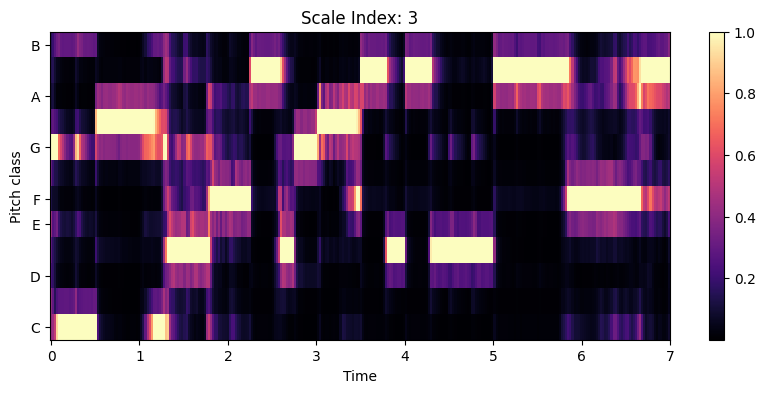

In [70]:
import matplotlib.pyplot as plt
import librosa.display

chroma = X_train[12].squeeze(0).numpy()  # [12, T]
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.title(f"Scale Index: {y_train[12]}")
plt.colorbar()
plt.show()

### Model Specifications

In [71]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChromaLite().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Core Training Loop

In [86]:
from tqdm import tqdm
def train_single_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in data_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = loss_fn(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    avg_loss = running_loss / len(data_loader)

    return avg_loss, train_acc

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    return correct / total

def train(model, train_loader, test_loader, loss_fn, optimizer, device, epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_loss, train_acc = train_single_epoch(model, train_loader, loss_fn, optimizer, device)
        test_acc = evaluate(model, test_loader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

        if epoch == epochs - 1:
          epochs_range = range(1, len(train_losses) + 1)

          plt.figure(figsize=(14, 5))

          # Accuracy plot
          plt.subplot(1, 2, 1)
          plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
          plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
          plt.title('Accuracy Over Epochs')
          plt.xlabel('Epoch')
          plt.ylabel('Accuracy')
          plt.legend()
          plt.grid(True, alpha=0.3)

          # Loss plot
          plt.subplot(1, 2, 2)
          plt.plot(epochs_range, train_losses, label='Train Loss')
          plt.title('Training Loss Over Epochs')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.legend()
          plt.grid(True, alpha=0.3)

          plt.tight_layout()
          plt.show()
        print("-" * 70)



Epoch 1/8
Train Loss: 3.1844 | Train Acc: 0.0381 | Test Acc: 0.1111
----------------------------------------------------------------------

Epoch 2/8
Train Loss: 2.9649 | Train Acc: 0.1268 | Test Acc: 0.2641
----------------------------------------------------------------------

Epoch 3/8
Train Loss: 2.0449 | Train Acc: 0.3735 | Test Acc: 0.4747
----------------------------------------------------------------------

Epoch 4/8
Train Loss: 1.0594 | Train Acc: 0.6802 | Test Acc: 0.7042
----------------------------------------------------------------------

Epoch 5/8
Train Loss: 0.5199 | Train Acc: 0.8537 | Test Acc: 0.7547
----------------------------------------------------------------------

Epoch 6/8
Train Loss: 0.2804 | Train Acc: 0.9385 | Test Acc: 0.8023
----------------------------------------------------------------------

Epoch 7/8
Train Loss: 0.1529 | Train Acc: 0.9759 | Test Acc: 0.7893
----------------------------------------------------------------------

Epoch 8/8
Train Los

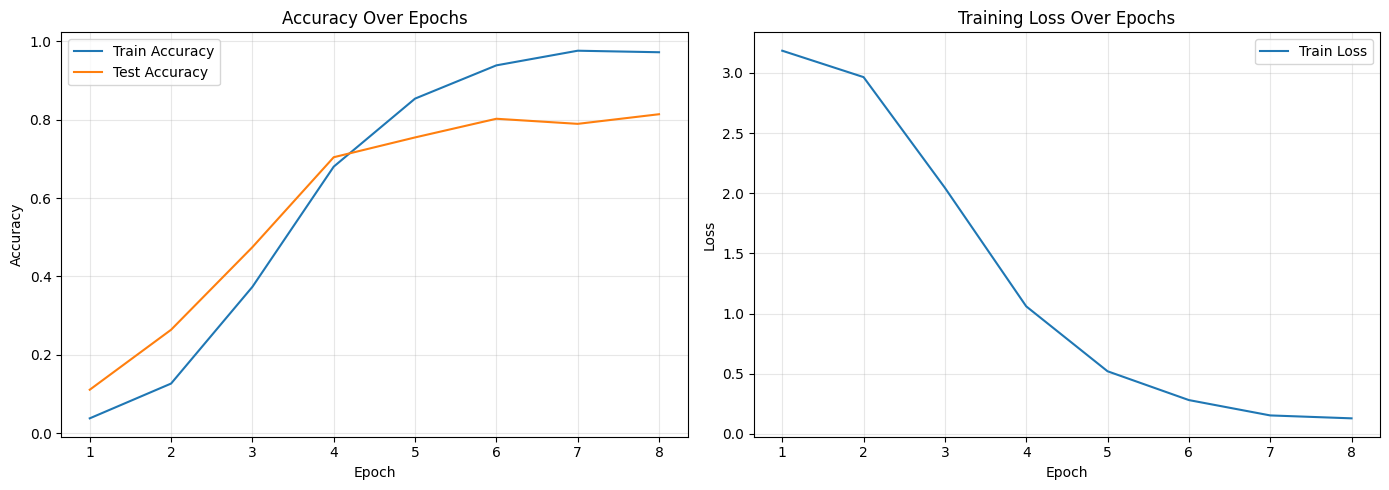

----------------------------------------------------------------------


In [87]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChromaLite().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=8)